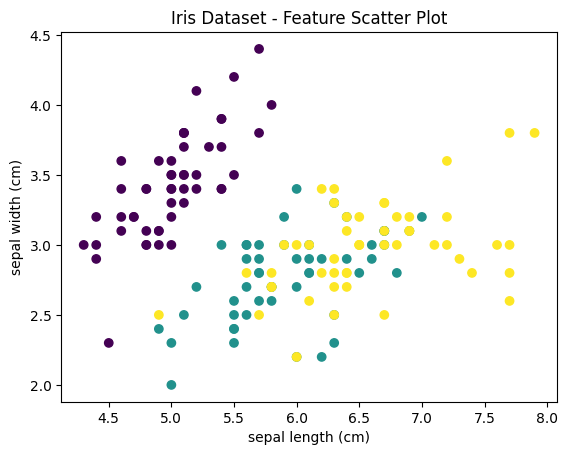

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt

# Load sample dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Scatter plot of first two features
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title("Iris Dataset - Feature Scatter Plot")
plt.show()

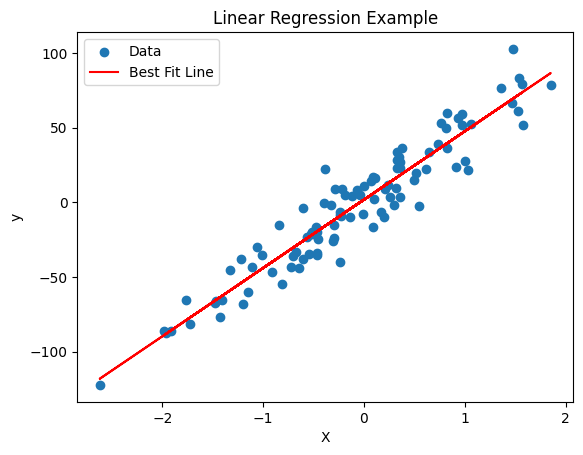

In [2]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

# Generate sample regression data
X, y = make_regression(n_samples=100, n_features=1, noise=15, random_state=42)

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict values
y_pred = model.predict(X)

# Plot data and best-fit line
plt.scatter(X, y, label="Data")
plt.plot(X, y_pred, color="red", label="Best Fit Line")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Linear Regression Example")
plt.legend()
plt.show()


In [4]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mse)

print(f"R²: {r2:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

R²: 0.907
MSE: 175.622
RMSE: 13.252
MAE: 10.657
